In [1]:
from conf import databases, url, data_dir
from file_utils import create_folder
from dnn_helper import *

import numpy
import random
import time

import lasagne
from matplotlib import pyplot as plt
import matplotlib as mpl

Using gpu device 0: GeForce GTX 1050 Ti (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5110)
/home/jdu/anac3.5/lib/python3.5/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [7]:
print(databases)

[('mitdb', ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']), ('ltdb', ['14046', '14134', '14149', '14157', '14172', '14184', '15814']), ('edb', ['e0103', 'e0104', 'e0105', 'e0106', 'e0107', 'e0108', 'e0110', 'e0111', 'e0112', 'e0113', 'e0114', 'e0115', 'e0116', 'e0118', 'e0119', 'e0121', 'e0122', 'e0123', 'e0124', 'e0125', 'e0126', 'e0127', 'e0129', 'e0133', 'e0136', 'e0139', 'e0147', 'e0148', 'e0151', 'e0154', 'e0155', 'e0159', 'e0161', 'e0162', 'e0163', 'e0166', 'e0170', 'e0202', 'e0203', 'e0205', 'e0206', 'e0207', 'e0208', 'e0210', 'e0211', 'e0212', 'e0213', 'e0302', 'e0303', 'e0304', 'e0305', 'e0306', 'e0403', 'e0404', 'e0405', 'e0406', 'e0408', 'e0409', 'e0410', 'e0411', 'e0413', 'e0415', 'e0417',

In [2]:
# databases = [
#      # Arrhythmia
#     ('mitdb', ["100", "101", "102", "103", "104", "105", "106", "107", "108", "109", "111", "112", "113", "114", "115", "116", "117", "118", "119", "121", "122", "123", "124", "200", "201", "202", "203", "205", "207", "208", "209", "210", "212", "213", "214", "215", "217", "219", "220", "221", "222", "223", "228", "230", "231", "232", "233", "234"]),
# #     ('ltdb', ["14046", "14134", "14149", "14157", "14172", "14184", "15814"]),
# ]

In [3]:
fs = 128
trained_fs = 360
min_bpm = 10
max_bpm = 350
min_gap = fs*60/min_bpm
max_gap = fs*60/max_bpm

# NN params
segment_size = 5000
segment_step = 2500
y_delay = 0

train_perc = 99
test_perc = 100 - train_perc

# Border suppression for evaluation
left_border  = 50 # samples
right_border = 50 # samples

In [4]:
model_path = 'saved-models/170514'
create_folder(model_path)

In [5]:
from theano import tensor, function, config
from theano.tensor import basic, clip
from lasagne.updates import adam, nesterov_momentum
from lasagne.layers import InputLayer, DenseLayer, Conv1DLayer, BiasLayer, DropoutLayer,\
                           get_output, get_all_params, set_all_param_values,\
                           get_output_shape, ConcatLayer,get_all_param_values
from lasagne.nonlinearities import sigmoid, rectify
from lasagne.init import GlorotUniform
from theano.printing import Print
from lasagne.regularization import regularize_network_params, l2, l1

def my_loss(model, predictions, targets, regularization):
    predictions = predictions[0][0][left_border:-right_border]
    targets = targets[0][left_border:-right_border]
    loss = tensor.abs_(tensor.log((targets * predictions).sum() / targets.sum())) +\
           tensor.abs_(tensor.log(((1-targets) * (1-predictions)).sum() / (1-targets).sum()))
    reg_loss_l1 = regularize_network_params(model, l1) * 1e-4
    reg_loss_l2 = regularize_network_params(model, l2)
    if regularization:
        return loss + reg_loss_l1# + reg_loss_l2
    else:
        return loss

In [8]:
class NN:
    def __init__(self, model_builder, dim, params):
        self.t_in = tensor.ftensor3('inputs')  #  =X     float64
        self.t_out = tensor.imatrix('targets') # =Y_true int32
        self.input_shape = (None, dim, segment_size,)
        self.output_shape  = (None, dim, segment_size,)
        self.model = model_builder(self.t_in, dim=dim, shape=self.input_shape)
        self.init_funs(self.model)
        self.params = params
    
    def init_funs(self, model):
        test_pred = get_output(self.model, deterministic=True)
        test_loss = my_loss(self.model, test_pred, self.t_out, False)
        test_loss_with_reg = my_loss(self.model, test_pred, self.t_out, True)
        test_acc  = tensor.mean(tensor.eq(tensor.argmax(test_pred, axis=1), self.t_out), dtype=config.floatX)
        
        self.eval_fn  = function([self.t_in, self.t_out], [test_loss, test_loss_with_reg, test_acc], allow_input_downcast=True)
        self.evaluate = function([self.t_in], get_output(self.model, self.t_in), allow_input_downcast=True)
        
        pred = get_output(self.model)
        loss_with_reg = my_loss(self.model, pred, self.t_out, True)
        params = get_all_params(self.model, trainable=True)
        updates = adam(loss_with_reg, params=params, learning_rate=0.0001)
        self.train_fn = function([self.t_in, self.t_out], loss_with_reg, updates=updates, allow_input_downcast=True)
    
    def train(self, train_exs, test_exs, num_epochs, examples_by_epoch, stop_accuracy=100.0, info=False):
        trainN, testN = len(train_exs), len(test_exs)
        print('Training on {} examples, testing on {} examples.'.format(trainN, testN))
        print("Starting training...")
        
        ex_count = 0
        train_losses = []
        rps = []
        for epoch in range(1, num_epochs+1):
            if epoch < 3:
                train_losses = []
            start_time = time.time()
            print('Epoch {}/{} running...'.format(epoch, num_epochs), end='')
            train_loss = 0
            train_loss_with_reg = 0
            invalid_example = 0
            for z in range(examples_by_epoch):
                db, i, j = train_exs[ex_count%trainN]
                XY = load_steps(db, i, *self.params)[j]
                x, y = numpy.reshape(XY[0], (1, 1, 5000)).astype('float16'), numpy.reshape(XY[1], (1, 5000)).astype('float16')
                ex_count += 1
                if numpy.sum(y) == 0.:
                    invalid_example += 1
                    continue
                tmp_loss = self.train_fn(x, y)
                train_loss += tmp_loss
                train_losses.append(train_loss/(z+1-invalid_example))
            print('Done in {:.3f}s!'.format(time.time() - start_time))
            print("  - training loss:\t\t{:.6f}".format(train_loss / (examples_by_epoch-invalid_example)))
            
            # Eval on examples:
            test_loss = 0
            test_reg_loss = 0
            test_acc = 0
            invalid_example = 0
            for k in range(testN):
                db, i, j = train_exs[k]
                XY = load_steps(db, i, *self.params)[j]
                x, y = numpy.reshape(XY[0], (1, 1, 5000)).astype('float16'), numpy.reshape(XY[1], (1, 5000)).astype('float16')
                if numpy.sum(y) == 0.:
                    invalid_example += 1
                    continue
                tmp_loss, tmp_reg_loss, tmp_acc = self.eval_fn(x, y)
                test_loss += tmp_loss
                test_reg_loss += (tmp_reg_loss-tmp_loss)
                test_acc  += tmp_acc
            N = (testN-invalid_example)
            print("  - test loss:\t\t\t{:.6f} | {:.6f} | {:.6f}".format(test_loss / N, test_reg_loss / N, (test_loss+test_reg_loss) / N))
            acc = test_acc / N * 100
            print("  - test accuracy:\t\t{:.4f} %".format(acc))
            plt.plot(train_losses, color='r')
            plt.plot(rps, color='g')
            plt.show()
            eval_model(test_exs, self.evaluate, min_gap, max_gap, left_border, right_border, *self.params,
                       plot_examples=True, nb=3, nearest_fpr=0.01, threshold=0.95, eval_margin=10)
            save_model(model_path + '/model-loss{}-epoch{}.sav'.format(test_loss / N, epoch), self.model, get_all_param_values(self.model))
            if acc > stop_accuracy:
                break
    
    def eval_data(self, x, fs_target):
        fs_target, y_delay, segment_size, segment_step, normalized_steps = self.params
        

In [10]:
def build_model(input_tensor, dim, shape=None):
    print('Model shape:')
    
    l_in = InputLayer(shape, input_var=input_tensor)
    
    print('  Layer A:')
    a1 = Conv1DLayer(l_in, num_filters=8, filter_size=(3), nonlinearity=rectify, pad='same')
    print('    a1:', get_output_shape(a1))
    a2 = Conv1DLayer(l_in, num_filters=64, filter_size=(15), nonlinearity=rectify, pad='same')
    print('    a2:', get_output_shape(a2))
    a3 = Conv1DLayer(l_in, num_filters=64, filter_size=(45), nonlinearity=rectify, pad='same')
    print('    a3:', get_output_shape(a3))
    a4 = Conv1DLayer(l_in, num_filters=32, filter_size=(89), nonlinearity=rectify, pad='same')
    print('    a4:', get_output_shape(a4))
    a5 = Conv1DLayer(l_in, num_filters=16, filter_size=(149), nonlinearity=rectify, pad='same')
    print('    a5:', get_output_shape(a5))
    a6 = Conv1DLayer(l_in, num_filters=16, filter_size=(199), nonlinearity=rectify, pad='same')
    print('    a6:', get_output_shape(a6))
    a7 = Conv1DLayer(l_in, num_filters=16, filter_size=(299), nonlinearity=rectify, pad='same')
    print('    a7:', get_output_shape(a7))
    al = ConcatLayer([a1, a2, a3, a4, a5, a6, a7], axis=1)
    print('   al:', get_output_shape(al))

    ad = DropoutLayer(al, p=0.5)

    print('  Layer B:')
    b1 = Conv1DLayer(ad, num_filters=8, filter_size=3, nonlinearity=rectify, pad='same')
    print('    b1:', get_output_shape(b1))
    b2 = Conv1DLayer(ad, num_filters=64, filter_size=9, nonlinearity=rectify, pad='same')
    print('    b2:', get_output_shape(b2))
    b3 = Conv1DLayer(ad, num_filters=64, filter_size=19, nonlinearity=rectify, pad='same')
    print('    b3:', get_output_shape(b3))
    b4 = Conv1DLayer(ad, num_filters=64, filter_size=39, nonlinearity=rectify, pad='same')
    print('    b4:', get_output_shape(b4))
    bl = ConcatLayer([b1, b2, b3], axis=1)
    print('   bl:', get_output_shape(bl))
    
    bd = DropoutLayer(bl, p=0.5)

    print('  Layer C:')
    c1 = Conv1DLayer(bd, num_filters=8, filter_size=3, nonlinearity=rectify, pad='same')
    print('    c1:', get_output_shape(c1))
    c2 = Conv1DLayer(bd, num_filters=32, filter_size=5, nonlinearity=rectify, pad='same')
    print('    c2:', get_output_shape(c2))
    c3 = Conv1DLayer(bd, num_filters=32, filter_size=9, nonlinearity=rectify, pad='same')
    print('    c3:', get_output_shape(c3))
    c4 = Conv1DLayer(bd, num_filters=32, filter_size=15, nonlinearity=rectify, pad='same')
    print('    c4:', get_output_shape(c4))
    c5 = Conv1DLayer(bd, num_filters=32, filter_size=19, nonlinearity=rectify, pad='same')
    print('    c5:', get_output_shape(c5))
    cl = ConcatLayer([c1, c2, c3, c4, c5])
    print('   cl:', get_output_shape(cl))
    
    cd = DropoutLayer(cl, p=0.4)
    
    print('  Layer D:')
    d1 = Conv1DLayer(cd, num_filters=8, filter_size=3, nonlinearity=rectify, pad='same')
    print('    d1:', get_output_shape(d1))
    d2 = Conv1DLayer(cd, num_filters=32, filter_size=5, nonlinearity=rectify, pad='same')
    print('    d2:', get_output_shape(d2))
    d3 = Conv1DLayer(cd, num_filters=64, filter_size=15, nonlinearity=rectify, pad='same')
    print('    d3:', get_output_shape(d3))
    dl = ConcatLayer([d1, d2, d3])
    print('   dl:', get_output_shape(dl))
    
    dd = DropoutLayer(dl, p=0.3)
    
    print('  Later E:')
    e1 = Conv1DLayer(dd, num_filters=16, filter_size=5, nonlinearity=rectify, pad='same')
    print('    e1:', get_output_shape(e1))
    e2 = Conv1DLayer(dd, num_filters=16, filter_size=15, nonlinearity=rectify, pad='same')
    print('    e2:', get_output_shape(e2))
    e3 = Conv1DLayer(dd, num_filters=16, filter_size=19, nonlinearity=rectify, pad='same')
    print('    e3:', get_output_shape(e3))
    el = ConcatLayer([e1, e2, e3])
    print('   el:', get_output_shape(el))
    
    ed = DropoutLayer(el, p=0.2)
    
    print('  Layer F:')
    f1 = Conv1DLayer(ed, num_filters=8, filter_size=3, nonlinearity=rectify, pad='same')
    print('    f1:', get_output_shape(f1))
    f2 = Conv1DLayer(ed, num_filters=16, filter_size=9, nonlinearity=rectify, pad='same')
    print('    f2:', get_output_shape(f2))
    f3 = Conv1DLayer(ed, num_filters=16, filter_size=15, nonlinearity=rectify, pad='same')
    print('    f3:', get_output_shape(f3))
    fl = ConcatLayer([f1, f2, f3])
    print('   fl:', get_output_shape(fl))
    
    fd = DropoutLayer(fl, p=0.1)
    
    print('  Layer G:')
    g1 = Conv1DLayer(fd, num_filters=1, filter_size=3, nonlinearity=sigmoid, pad='same')
    print('    g1:', get_output_shape(g1))
    gl = ConcatLayer([g1])
    print('   gl:', get_output_shape(gl))
    
    return gl


nn = NN(dim=1, model_builder=build_model, params=(360, 5000, 2500, True, True))

Model shape:
  Layer A:
    a1: (None, 8, 5000)
    a2: (None, 64, 5000)
    a3: (None, 64, 5000)
    a4: (None, 32, 5000)
    a5: (None, 16, 5000)
    a6: (None, 16, 5000)
    a7: (None, 16, 5000)
   al: (None, 216, 5000)
  Layer B:
    b1: (None, 8, 5000)
    b2: (None, 64, 5000)
    b3: (None, 64, 5000)
    b4: (None, 64, 5000)
   bl: (None, 136, 5000)
  Layer C:
    c1: (None, 8, 5000)
    c2: (None, 32, 5000)
    c3: (None, 32, 5000)
    c4: (None, 32, 5000)
    c5: (None, 32, 5000)
   cl: (None, 136, 5000)
  Layer D:
    d1: (None, 8, 5000)
    d2: (None, 32, 5000)
    d3: (None, 64, 5000)
   dl: (None, 104, 5000)
  Later E:
    e1: (None, 16, 5000)
    e2: (None, 16, 5000)
    e3: (None, 16, 5000)
   el: (None, 48, 5000)
  Layer F:
    f1: (None, 8, 5000)
    f2: (None, 16, 5000)
    f3: (None, 16, 5000)
   fl: (None, 40, 5000)
  Layer G:
    g1: (None, 1, 5000)
   gl: (None, 1, 5000)


In [ ]:
exs = shuffled_examples(360, 5000, 2500, True, True)
train_exs = exs[:int(len(exs)*train_perc/100)]
test_exs  = exs[int(len(exs)*train_perc/100):]
print('Number of examples: {} ({} samples)'.format(len(exs), len(exs)*5000))
print('          Training: {} ({} samples)'.format(len(train_exs), len(train_exs)*5000))
print('           Testing: {} ({} samples)'.format(len(test_exs), len(test_exs)*5000))

Number of examples: 180975 (904875000 samples)
          Training: 179165 (895825000 samples)
           Testing: 1810 (9050000 samples)


Training on 179165 examples, testing on 1810 examples.
Starting training...
Epoch 1/500 running...Done in 60.159s!
  - training loss:		1.925118
  - test loss:			0.101963 | 1.347431 | 1.449394
  - test accuracy:		99.6513 %


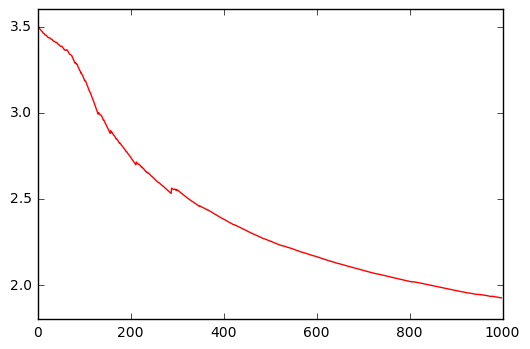

Example 973
(1, 1, 5000) (5000,)
Number of peak ranges found: 16
Example 314
(1, 1, 5000) (5000,)
Number of peak ranges found: 13
Example 965
(1, 1, 5000) (5000,)
Number of peak ranges found: 19


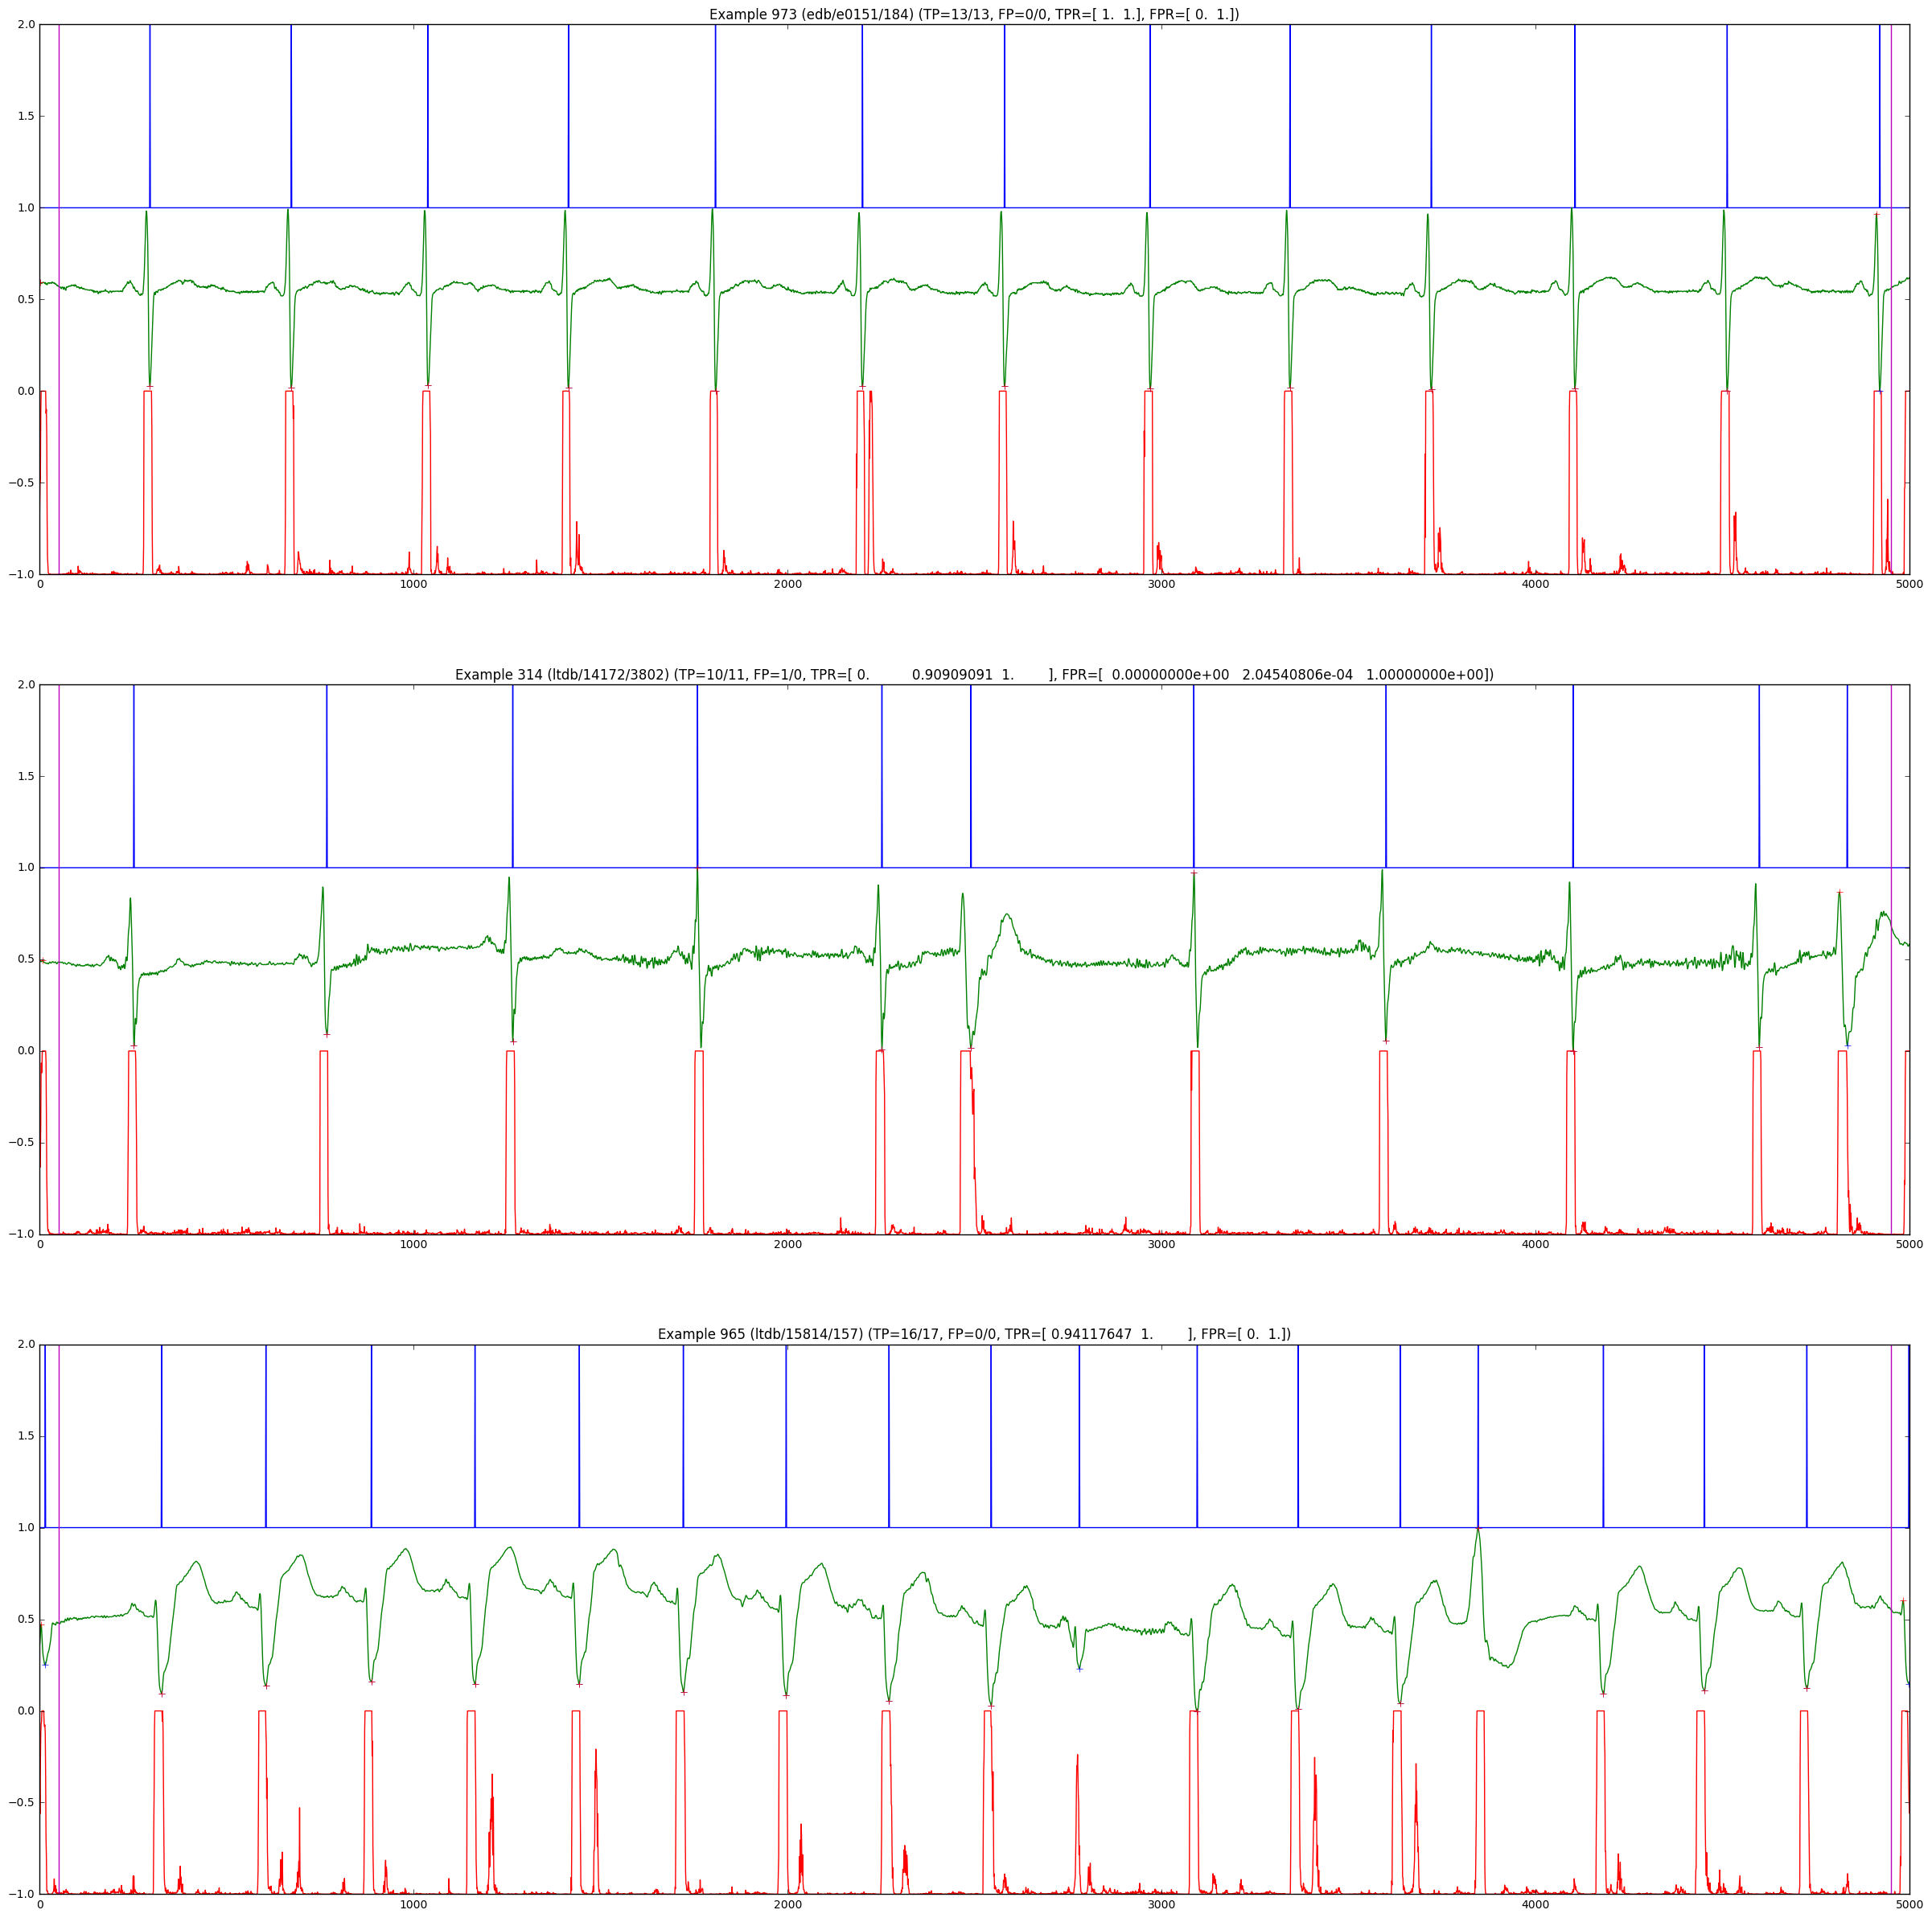

FPR			TPR			Threshold
0.007504		0.975610\+t	0.2663024


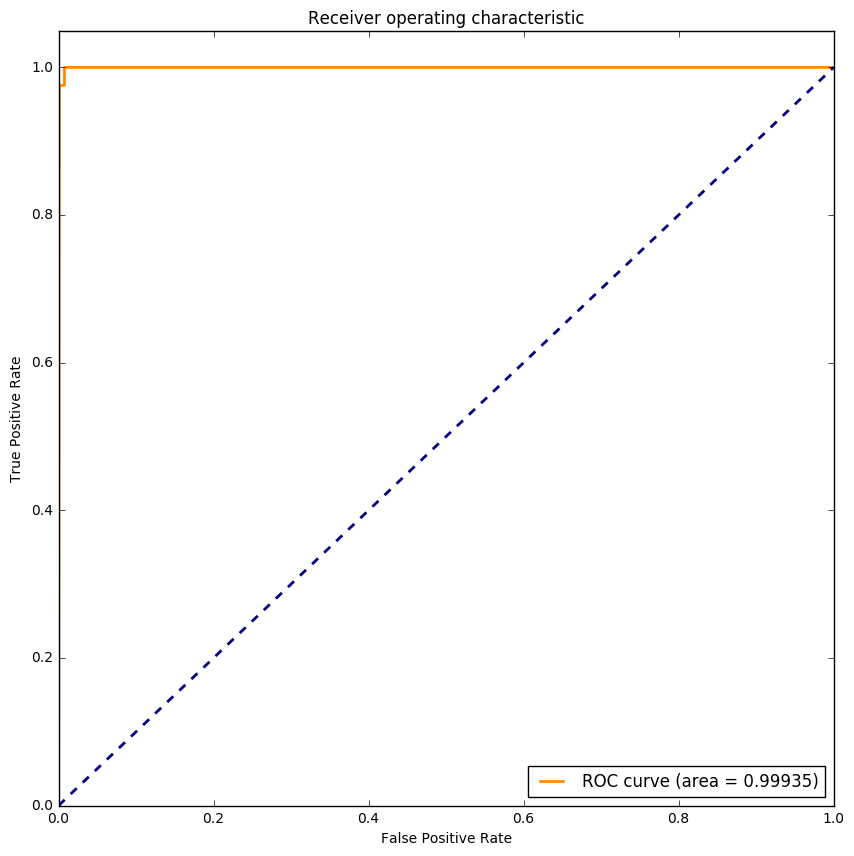

Samples:		14700 samples
Beats:
  - 41 labelized
  - 54 detected
  - TP:  40/41
  - FP:  14/0
  - TPR: 0.9756
Epoch 2/500 running...

In [ ]:
nn.train(train_exs, test_exs, num_epochs=500, examples_by_epoch=1000, info=True)

In [ ]:
_, params = load_model(model_path + '/model-loss0.037631392673427445-epoch1200.sav')
# print(params)
set_all_param_values(nn.model, params)
nn.init_funs(nn.model)

In [ ]:
eval_model(testXY, nn.evaluate, left_border=left_border, right_border=right_border,
           min_gap=min_gap, max_gap=max_gap, plot_examples=True, nb=10,
           nearest_fpr=0.000675, threshold=0.9678147, eval_margin=10)